In [100]:
import random
import numpy as np
from collections import deque

import torch
import torch.nn as nn
import torch.autograd as autograd
import torch.nn.functional as F
import torch.optim as optim
from torchsummary import summary
import gym
import math
from itertools import count
import time
import sys
import collections
from torch.utils.tensorboard import SummaryWriter
from nes_py.wrappers import JoypadSpace
import gym_super_mario_bros
from gym_super_mario_bros.actions import COMPLEX_MOVEMENT, SIMPLE_MOVEMENT

from torch.utils.tensorboard import SummaryWriter
import matplotlib.pyplot as plt
import time

In [101]:
# Checkout original env
env = gym_super_mario_bros.make('SuperMarioBros-1-1-v0')

env = JoypadSpace(env, SIMPLE_MOVEMENT)
print(env.observation_space)

Box(0, 255, (240, 256, 3), uint8)


In [102]:
# Taken from with modfication (float  -> uint8  for memory efficiency)
# https://github.com/PacktPublishing/Deep-Reinforcement-Learning-Hands-On/blob/master/Chapter06/lib/wrappers.py


import cv2
import numpy as np
import collections


class MaxAndSkipEnv(gym.Wrapper):
    def __init__(self, env=None, skip=4):
        super(MaxAndSkipEnv, self).__init__(env)
        # most recent raw observations (for max pooling across time steps)
        self._obs_buffer = collections.deque(maxlen=2)
        self._skip = skip

    def step(self, action):
        total_reward = 0.0
        done = None
        for _ in range(self._skip):
            obs, reward, done, info = self.env.step(action)
            self._obs_buffer.append(obs)
            total_reward += reward
            if done:
                break
        max_frame = np.max(np.stack(self._obs_buffer), axis=0)
        return max_frame, total_reward, done, info

    def reset(self):
        self._obs_buffer.clear()
        obs = self.env.reset()
        self._obs_buffer.append(obs)
        return obs


class ProcessFrame128(gym.ObservationWrapper):
    def __init__(self, env=None):
        super(ProcessFrame128, self).__init__(env)
        self.observation_space = gym.spaces.Box(low=0, high=255, shape=(128, 128, 1), dtype=np.uint8)

    def observation(self, obs):
        return ProcessFrame128.process(obs)

    @staticmethod
    def process(frame):
        if frame.size == 240 * 256 * 3:
            img = np.reshape(frame, [240, 256, 3]).astype(np.float32)
        else:
            assert False, "Unknown resolution."
        img = img[:, :, 0] * 0.299 + img[:, :, 1] * 0.587 + img[:, :, 2] * 0.114
        resized_screen = cv2.resize(img, (128, 128), interpolation=cv2.INTER_AREA)
        x_t = np.reshape(resized_screen, [128, 128, 1])
        return x_t.astype(np.uint8)

class BufferWrapper(gym.ObservationWrapper):
    # def __init__(self, env, n_steps, dtype=np.float32):
    def __init__(self, env, n_steps, dtype=np.uint8):
        super(BufferWrapper, self).__init__(env)
        self.dtype = dtype
        old_space = env.observation_space
        self.observation_space = gym.spaces.Box(old_space.low.repeat(n_steps, axis=0),
                                                old_space.high.repeat(n_steps, axis=0), dtype=dtype)

    def reset(self):
        self.buffer = np.zeros_like(self.observation_space.low, dtype=self.dtype)
        return self.observation(self.env.reset())

    def observation(self, observation):
        self.buffer[:-1] = self.buffer[1:]
        self.buffer[-1] = observation
        return self.buffer


class ImageToPyTorch(gym.ObservationWrapper):
    def __init__(self, env):
        super(ImageToPyTorch, self).__init__(env)
        old_shape = self.observation_space.shape
        self.observation_space = gym.spaces.Box(low=0, high=255, shape=(old_shape[-1], 
                                old_shape[0], old_shape[1]), dtype=np.uint8)
        # self.observation_space = gym.spaces.Box(low=0.0, high=1.0, shape=(old_shape[-1], 
        #                         old_shape[0], old_shape[1]), dtype=np.float32)        

    def observation(self, observation):
        return np.moveaxis(observation, 2, 0)


class ScaledFloatFrame(gym.ObservationWrapper):
    def observation(self, obs):
        return np.array(obs).astype(np.uint8) 

def wrap_env(env):
    env = MaxAndSkipEnv(env)
    env = ProcessFrame128(env)
    env = ImageToPyTorch(env)
    env = BufferWrapper(env, 4)
    return ScaledFloatFrame(env)
   

Box(0, 255, (4, 128, 128), uint8)
Discrete(7)


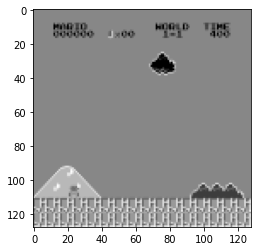

In [103]:
# Checkout wrapped env
t_env = gym_super_mario_bros.make('SuperMarioBros-1-1-v0')

t_env = JoypadSpace(t_env, SIMPLE_MOVEMENT)
t_env = wrap_env(t_env)
fr = t_env.reset()
plt.imshow(fr[3,:,:], cmap = "Greys")
print(t_env.observation_space)
print(t_env.action_space)

In [104]:
# Experience replay buffer
Experience = collections.namedtuple('Experience', field_names=['state', 'action', 'reward', 'new_state', 'done'])

class ExpBuffer:
    def __init__(self, max_size):
        self.max_size = max_size
        self.buffer = deque(maxlen=max_size)

    def __len__(self):
        return len(self.buffer)
    
    def push(self, experience):
        self.buffer.append(experience)

    def sample(self, batch_size):
        idxs = np.random.choice(len(self.buffer), batch_size, replace=False)
        states, actions, rewards, next_states, dones = zip(*[self.buffer[i] for i in idxs])
        return np.array(states), np.array(actions), np.array(rewards), np.array(next_states), np.array(dones)


In [105]:
# Taken from 
# https://github.com/PacktPublishing/Deep-Reinforcement-Learning-Hands-On/blob/master/Chapter06/lib/dqn_model.py

import numpy as np

class DQN(nn.Module):
    def __init__(self, input_shape, n_actions):
        super(DQN, self).__init__()

        self.conv = nn.Sequential(
            nn.Conv2d(input_shape[0], 32, kernel_size=8, stride=4),
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=4, stride=2),
            nn.ReLU(),
            nn.Conv2d(64, 64, kernel_size=3, stride=1),
            nn.ReLU()
        )

        conv_out_size = self._get_conv_out(input_shape)
        self.fc = nn.Sequential(
            nn.Linear(conv_out_size, 512),
            nn.ReLU(),
            nn.Linear(512, n_actions)
        )

    def _get_conv_out(self, shape):
        o = self.conv(torch.zeros(1, *shape))
        return int(np.prod(o.size()))

    def forward(self, x):
        conv_out = self.conv(x).view(x.size()[0], -1)
        return self.fc(conv_out)

In [106]:
# Checkout the network
t_env.reset()
print(t_env.observation_space)

net = DQN(t_env.observation_space.shape, t_env.action_space.n )

summary(net, input_size=t_env.observation_space.shape,  device="cpu")

Box(0, 255, (4, 128, 128), uint8)
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 31, 31]           8,224
              ReLU-2           [-1, 32, 31, 31]               0
            Conv2d-3           [-1, 64, 14, 14]          32,832
              ReLU-4           [-1, 64, 14, 14]               0
            Conv2d-5           [-1, 64, 12, 12]          36,928
              ReLU-6           [-1, 64, 12, 12]               0
            Linear-7                  [-1, 512]       4,719,104
              ReLU-8                  [-1, 512]               0
            Linear-9                    [-1, 7]           3,591
Total params: 4,800,679
Trainable params: 4,800,679
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.25
Forward/backward pass size (MB): 0.81
Params size (MB): 18.31
Estimated Total Size (MB): 19.37
---

In [107]:

class DQNAgent:
    
    def __init__(self, env, buffer_size=100000):
        self.env = env
        self.replay_buffer = ExpBuffer(max_size=buffer_size)
        self.reset()
        self.device = "cpu"
        if torch.cuda.is_available():
            self.device = "cuda"

        self.model = DQN(env.observation_space.shape, env.action_space.n).to(self.device)
        self.target_model = DQN(env.observation_space.shape, env.action_space.n).to(self.device)
        self.target_model.load_state_dict(self.model.state_dict())
        self.target_model.eval()
        # self.optimizer = torch.optim.RMSprop(self.model.parameters(), lr = 1e-4 )
        self.optimizer = optim.Adam(self.model.parameters(), lr=0.00025)

        self.loss_func =  nn.SmoothL1Loss()
    
    def reset(self):
        self.total_reward = 0.0
        self.state = self.env.reset()
        
    def play(self, eps):
        # random sample action
        action = 0
        if(np.random.random() < eps):
            action = self.env.action_space.sample()
        # choose action with highest Q value
        else:
            state_tensor = torch.FloatTensor(self.state.astype(np.float32) / 255.0).unsqueeze(0).to(self.device)
            # state_tensor = torch.FloatTensor(self.state).unsqueeze(0).to(self.device)
            qvals_tensor = self.model(state_tensor)
            action = int(np.argmax(qvals_tensor.cpu().detach().numpy()))
        next_state, reward, done, _ = self.env.step(action)
        experience = Experience(self.state, action, reward, next_state, done)

        self.replay_buffer.push(experience)
        self.state = next_state
        self.total_reward += reward
        if(done):
            res_reward = self.total_reward
            self.reset()
            return res_reward
        else:
            return None
    def load_params(self, file_name):
        print(self.model.load_state_dict(torch.load(file_name)))
    def copy_to_target(self):
        print("Copying to target")
        self.target_model.load_state_dict(self.model.state_dict())

In [108]:
def train_model(agent, max_episodes, writer, expected_reward = 150, replay_start = 16384, batch_size = 32, gamma = 0.99, update_inverval = 1000, eps_start = 0.9, eps_end = 0.05, eps_decay = 0.999999):
    episode_rewards = []
    eps = eps_start
    # Total steps played 
    total_steps = 0
    best_mean_reward = 1000.0
    
    model_no = 0
    for episode in range(max_episodes):
    
        for step in count():
            total_steps += 1
            eps = max(eps*eps_decay, eps_min)

            episode_reward = agent.play(eps)
            if(episode_reward is not None):
                episode_rewards.append(episode_reward)
                mean_reward = np.mean(episode_rewards[-100:])
                writer.add_scalar("epsilon", eps, total_steps)
                writer.add_scalar("last_100_reward", mean_reward, total_steps)
                writer.add_scalar("reward", episode_reward, total_steps)
                if(mean_reward > best_mean_reward and total_steps > replay_start):
                    best_mean_reward = mean_reward
                    # save the most recent 10 best models
                    torch.save(agent.model.state_dict(), "Local_DQN_Mario_no" + str(model_no))
                    print("Best mean reward updated, model saved")
                    model_no += 1
                    model_no = model_no % 10
                print("%d:  %d games, mean reward %.3f, epsilon %.2f" % (total_steps, episode, mean_reward, eps))
                break
            # start training only where there are enough data in replay buffer
            if len(agent.replay_buffer) < replay_start:
                continue
            batch = agent.replay_buffer.sample(batch_size)
            # Get a batch of exp from exp replay buffer
            states, actions, rewards, next_states, dones = batch
            states_tensor = torch.tensor(states.astype(np.float32) / 255.0, dtype=torch.float32).to(agent.device)
            # states_tensor = torch.tensor(states, dtype=torch.float32).to(agent.device)
            # must choose torch.LongTensor for actions, since index for gather function must be of int64
            actions_tensor = torch.tensor(actions, dtype=torch.long).to(agent.device)
            rewards_tensor = torch.tensor(rewards, dtype=torch.float32).to(agent.device)
            next_states_tensor = torch.tensor(next_states.astype(np.float32) / 255.0, dtype=torch.float32).to(agent.device)
            # next_states_tensor = torch.tensor(next_states, dtype=torch.float32).to(agent.device)
            dones_tensor = torch.BoolTensor(dones).to(agent.device)
            # print('+++++++')
            # print(states_tensor.shape)
            # print(actions_tensor.shape)
            # print(rewards_tensor.shape)
            # print(next_states_tensor.shape)
            # print(dones_tensor.shape)
            # get current Q value from the training network given the current action
            curr_Q = agent.model(states_tensor).gather(1, actions_tensor.unsqueeze(-1)).squeeze(-1)

            # get expected Q value for all possible actions using the target net, and pick the highest Qval, e = reward + gamma * Q'(s_next)
            max_next_Q = agent.target_model(next_states_tensor).max(1)[0]
            # if it's final state, i.e done = True, the next_Q = 0
            max_next_Q[dones_tensor] = 0.0
            expected_Q = rewards_tensor + gamma * max_next_Q.detach()

            loss = agent.loss_func(curr_Q, expected_Q)

            agent.optimizer.zero_grad()
            loss.backward()
            agent.optimizer.step()            



            # Copy params to target net for every $update_inverval steps
            if( total_steps % update_inverval == 0) :
                agent.copy_to_target()
            # Save a model every 250000 steps   
            if (total_steps % 250000 == 0):
                torch.save(agent.model.state_dict(), "Local_DQN_Mario_snapshot")
                print("snapshot saved")

        if (best_mean_reward >= expected_reward):
            break
    writer.close()
    return episode_rewards

In [109]:
env = gym_super_mario_bros.make('SuperMarioBros-1-1-v0')

env = JoypadSpace(env, SIMPLE_MOVEMENT)
env = wrap_env(env)

env.reset()
replay_buffer_size = 100000          


agent = DQNAgent(env, replay_buffer_size)




In [110]:
# agent.load_params("full_model_new_v5")
# agent.copy_to_target()

In [111]:
max_episodes = 30

gamma = 0.9                   
batch_size = 32                
update_interval = 10000    

# early termination if reward reaches the following value
expected_reward = 3000.0

# start training after the following number steps
replay_start = 100000

eps_start=1.0
eps_decay=0.9999975
eps_min=0.05

In [112]:
writer = SummaryWriter('runs/' + str(math.floor(time.time())) + '-mario_1_1-' + str(eps_decay) + '-' + str(replay_buffer_size))

In [113]:





episode_rewards = train_model(agent, max_episodes, writer, expected_reward, replay_start, batch_size, gamma, update_interval, eps_start, eps_min, eps_decay)


58:  0 games, mean reward 193.000, epsilon 1.00
261:  1 games, mean reward 654.500, epsilon 1.00
324:  2 games, mean reward 511.333, epsilon 1.00
370:  3 games, mean reward 442.500, epsilon 1.00
556:  4 games, mean reward 479.400, epsilon 1.00
667:  5 games, mean reward 507.000, epsilon 1.00
1701:  6 games, mean reward 558.143, epsilon 1.00
2377:  7 games, mean reward 686.500, epsilon 0.99
2421:  8 games, mean reward 635.333, epsilon 0.99
2535:  9 games, mean reward 631.600, epsilon 0.99
4254:  10 games, mean reward 641.000, epsilon 0.99


KeyboardInterrupt: 